# Capstone II: Predictive Binary from DJIA and Reuters articles
# Milestone Report II
Charita Ramnathsing July 2020

#Learning Objective
Integrate and apply the technical competency learned from the 3 technical units 

Utilize the work you have completed using Machine learning and the more advanced ML/specialization specific techniques to complete your report.

Detect and justify utilized machine learning techniques (if applicable to the project), including feature selection and evaluation metric/technique.



In [1]:
# basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# plotting interactive charts
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file, show
from bokeh.transform import factor_cmap
from bokeh.io import output_notebook, show

# text helper functions and modules
import nltk
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

# for punctuation
import string
# setting to date formats
from datetime import datetime

# use for text calculation
import statistics 
# mount the drive for easy read
from google.colab import drive

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd /content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [5]:
#read files
DJIA = pd.read_csv(
        "DJI_2018.csv",
        parse_dates=['Date']
    )

In [6]:
df_text = pd.read_csv('reuters_articles_for_prediction.csv', engine='python', error_bad_lines=False, encoding='utf8', usecols=['date','year', 'month', 'day', 'title', 'publication'])

Skipping line 353239: field larger than field limit (131072)


In [7]:
# filter only the Reuters articles
df_text = df_text[df_text.publication == 'Reuters']

In [8]:
# drop the columns which are not needed 
df_reuters = df_text.drop(['month', 'day', 'publication'], axis=1)

In [9]:
# filter articles for only the year '2018'
text_2018 = df_reuters[df_reuters['year'] == 2018].sort_index().drop('year', axis=1)

In [10]:
# format the date column to YYYY-MM-DD
text_2018.date = text_2018.date.str[:10]

In [11]:
text_2018 = text_2018.sort_values('date').reset_index()

#Text Manipulation for WordCloud

In [12]:
punc = list(set(string.punctuation))

In [13]:
porter = PorterStemmer()
lemma = nltk.stem.wordnet.WordNetLemmatizer()

In [14]:
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

In [15]:
def process_text(text):
    text = text.replace("U.S.", "usa")
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+-', '', each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in ENGLISH_STOP_WORDS]
    text = [each for each in text if len(each) > 1]
    text = [lemma.lemmatize(each) for each in text if not each.isnumeric()]
    return text


In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [17]:
vectorizer = TfidfVectorizer(max_df= 0.1, tokenizer = process_text, stop_words = ENGLISH_STOP_WORDS)
tdm = vectorizer.fit_transform(text_2018.title)

In [18]:
freqs = {word: tdm.getcol(idx).sum() for word, idx in vectorizer.vocabulary_.items()}

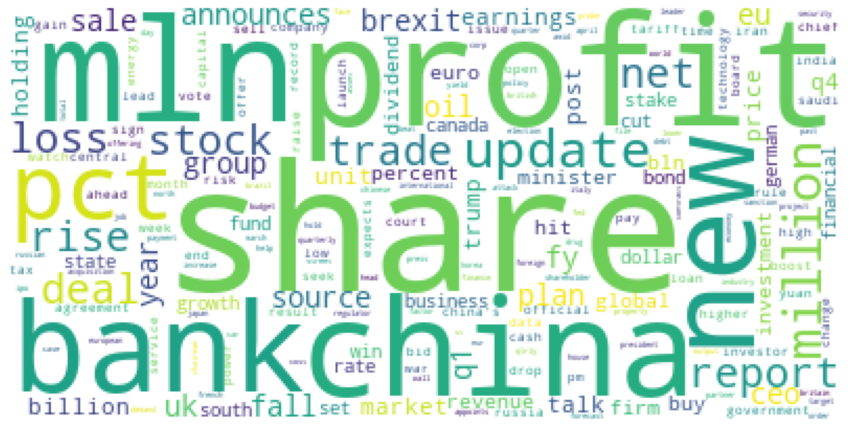

In [19]:
w = WordCloud(mode='RGBA',background_color='white').generate_from_frequencies(freqs)

plt.figure(figsize=(15,10))
plt.imshow(w)
plt.axis("off") 
plt.show()

# Visualization with Bokeh


In [20]:
# sort first
text_2018_sorted_by_date = text_2018.sort_values(by='date')

In [21]:
# make the DataFrame 'datetime' ready
text_2018_sorted_by_date['date'] = pd.to_datetime(text_2018_sorted_by_date.date)

In [22]:
# and then groupby for going through TextBlob
text_2018_sorted_by_date_blob = (sorted(text_2018_sorted_by_date.groupby(['date'])))

In [23]:
# since not all polarity and subjectivity can be taken on one day, i have calculated the average
def check_blob(df, txb_pol, txb_sub ):
    pol = []
    sub = []

    for i, t in df.iterrows(): 
        txb = TextBlob(t.title)
        pol.append(txb.polarity)
        sub.append(txb.subjectivity)
    txb_pol = np.mean(pol)
    txb_sub = np.mean(sub)

    return txb_pol, txb_sub

In [24]:
# Polarity and Subjectivity will be given into a list where each item in the list is an average
pol_per_date = []
sub_per_date = []
pol_blob = []
sub_blob = []
date_col = []

for i, item in text_2018_sorted_by_date_blob:
    pol_blob, sub_blob = check_blob(item.set_index('index'), pol_blob, sub_blob)
    pol_per_date.append(pol_blob)
    sub_per_date.append(sub_blob)
    # date is being formatted for better readability and further date-format for the visualization DataFrame 
    date_col.append(datetime.strftime(datetime.date(i), '%Y-%m-%d'))

In [25]:
# make dictionary and convert string Date time into Python Date time object for further plotting
visualization = {'Date': pd.to_datetime(date_col) , 'Polarity': pol_per_date, 'Subjectivity': sub_per_date }

In [26]:
# Import figure from bokeh.plotting
from bokeh.plotting import figure

source = ColumnDataSource(visualization)
sentiment = ['Polarity', 'Subjectivity']

# Create the figure: p
q = figure(plot_width=900, plot_height=400,x_axis_type='datetime')

# Plot Polarity and Subjectivity
q.circle(visualization['Date'], visualization['Polarity'], color='blue', size=5, legend_label='Polarity')
q.circle(visualization['Date'], visualization['Subjectivity'], color='green', size=5, legend_label='Subjectivity')

output_notebook()

In [ ]:
show(q)

# Visualization for Dow Jones Index with Bokeh

In [27]:
#make parameters ready for plotting of the DJIA-index
max_volume = max(DJIA.Volume)
djia_by_date = DJIA.reset_index()
djia_by_date['Volume mln'] = djia_by_date['Volume']/1000000
source = ColumnDataSource(djia_by_date)
TOOLS = "pan, wheel_zoom, box_zoom, box_select,reset, save"

# Graph has date on the x-axis
p = figure(title="Scroll over the graph for 'Open' and 'Close' numbers", x_axis_type='datetime', tools=TOOLS)
p.line(x='Date', y='Volume mln', source=source) #build a line chart
p.yaxis.axis_label = 'Traded Volumes - Dow Jones stocks portfolio (mln)'
p.xgrid.grid_line_color = None

# add a hover tool for Open and Close values and show the date in date time format
hover = HoverTool()
hover.tooltips=[
    ('Open', '@Open{0.2f}'),
    ('Close', '@Close{0.2f}')
]

p.add_tools(hover)

output_notebook() # show the output in jupyter notebook


In [ ]:
show(p)

#Setup for Neural Network use

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


In [29]:
# label data by adding column
djia_by_date['Up?'] =  djia_by_date['Open'] < djia_by_date['Close'] 

In [30]:
djia_by_date['Up?'].value_counts()

True     134
False    116
Name: Up?, dtype: int64

In [31]:
djia_sorted_by_date = djia_by_date.sort_values(['Date'])

In [32]:
djia_sorted_by_date['Date'] = djia_sorted_by_date['Date'].astype(str)

In [33]:
# format Date column to YYYY-MM-DD
djia_sorted_by_date.Date = djia_sorted_by_date.Date.str[:10]

In [34]:
djia_sorted_by_date[:5]

,index,Date,Open,High,Low,Close,Adj Close,Volume,Volume mln,Up?
0,0,2018-01-02,24809.349609,24864.189453,24741.699219,24824.009766,24824.009766,341130000,341.13,True
1,1,2018-01-03,24850.449219,24941.919922,24825.550781,24922.679688,24922.679688,456790000,456.79,True
2,2,2018-01-04,24964.859375,25105.960938,24963.269531,25075.130859,25075.130859,403280000,403.28,True
3,3,2018-01-05,25114.919922,25299.789063,25112.009766,25295.869141,25295.869141,358020000,358.02,True
4,4,2018-01-08,25308.400391,25311.990234,25235.410156,25283.000000,25283.000000,341390000,341.39,False


In [35]:
# Merge DataFrames for sorting per date and bringing all values together
df = djia_sorted_by_date.merge(text_2018, left_on='Date', right_on= 'date', how ='outer')

In [36]:
df = df.dropna(subset=['Date']).drop(['index_x', 'index_y'], axis=1).sort_values(by=['Date']).reset_index()

In [38]:
df.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume,Volume mln,Up?,date,title
0,0,2018-01-02,24809.349609,24864.189453,24741.699219,24824.009766,24824.009766,341130000.0,341.13,True,2018-01-02,Iran should restore social media sites restric...
1,84,2018-01-02,24809.349609,24864.189453,24741.699219,24824.009766,24824.009766,341130000.0,341.13,True,2018-01-02,CANADA STOCKS-TSX notches record high as resou...
2,83,2018-01-02,24809.349609,24864.189453,24741.699219,24824.009766,24824.009766,341130000.0,341.13,True,2018-01-02,BRIEF-Hengtai Securities Says Shareholders Ent...
3,82,2018-01-02,24809.349609,24864.189453,24741.699219,24824.009766,24824.009766,341130000.0,341.13,True,2018-01-02,BRIEF-Yonghui Superstores Signs Agreement With...
4,81,2018-01-02,24809.349609,24864.189453,24741.699219,24824.009766,24824.009766,341130000.0,341.13,True,2018-01-02,Property reinsurance rates rise less than expe...


In [39]:
pd.set_option('display.max_colwidth', 100)

#Prepare for Training and testing

**Train/Test split**

In [40]:
train_2018 = df[:27000]
test_2018 = df[27001:]

**Tokenize and generate sequences**

In [41]:
import tensorflow as tf
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
# fit the tokenizer on the documents
t.fit_on_texts(df['title'])
# word_index is the vocabulary size, initiate to 0
t.word_index['<PAD>'] = 0

In [42]:
train_sequences = t.texts_to_sequences(train_2018['title'])
test_sequences = t.texts_to_sequences(test_2018['title'])

In [43]:
MAX_SEQUENCE_LENGTH = 100 #number of max words per headline (document)

In [44]:
# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((27000, 100), (9961, 100))

In [45]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [46]:
# make target readable for tensor
y_train = le.fit_transform(train_2018['Up?'])
y_test = le.transform(test_2018['Up?'])

In [47]:
VOCAB_SIZE = len(t.word_index)

**Build Model Architecture 1**

In [73]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units
# start the tensor and add layers
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(LSTM_DIM, activation='relu',  recurrent_activation='sigmoid', return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))


**Compile the Model 1**

In [74]:
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          9860700   
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 300)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 10,113,629
Trainable params: 10,113,629
Non-trainable params: 0
_________________________________________________________________


**Train the Model 1**

In [75]:
batch_size = 128
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
190/190 [==============================] - 47s 249ms/step - loss: 0.6908 - accuracy: 0.5287 - val_loss: 0.6917 - val_accuracy: 0.5089
Epoch 2/10
190/190 [==============================] - 46s 243ms/step - loss: 0.6348 - accuracy: 0.6437 - val_loss: 0.7195 - val_accuracy: 0.5263
Epoch 3/10
190/190 [==============================] - 45s 237ms/step - loss: 0.4538 - accuracy: 0.7844 - val_loss: 0.8535 - val_accuracy: 0.5441
Epoch 00003: early stopping


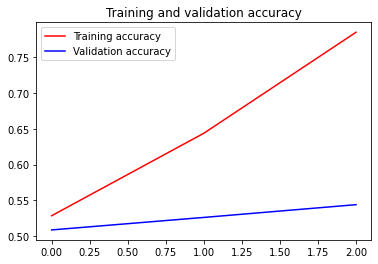

<Figure size 432x288 with 0 Axes>

In [76]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

**Accuracy and Loss Model 1**

In [77]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

312/312 [==============================] - 5s 15ms/step - loss: 0.6933 - accuracy: 0.4997
Accuracy: 49.97%


**Build Model Architecture 2 Stacked LSTM**

In [82]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model2.add(tf.keras.layers.SpatialDropout1D(0.1))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))
#model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model2.add(tf.keras.layers.Dense(256, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model2.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 300)          9860700   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 300)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
dense_12 (Dense)             (None, 100, 256)          33024     
_________________________________________________________________
dense_13 (Dense)             (None, 100, 1)            257       
Total params: 10,113,629
Trainable params: 10,113,629
Non-trainable params: 0
_________________________________________________________________


**Train Model 2**

In [83]:
batch_size = 128
EPOCHS = 10

es2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

history2 = model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
           callbacks=[es2],
           shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
190/190 [==============================] - 22s 116ms/step - loss: 0.6920 - accuracy: 0.5265 - val_loss: 0.6750 - val_accuracy: 0.7652
Epoch 2/10
190/190 [==============================] - 22s 113ms/step - loss: 0.6912 - accuracy: 0.5304 - val_loss: 0.6509 - val_accuracy: 0.7554
Epoch 3/10
190/190 [==============================] - 21s 112ms/step - loss: 0.6853 - accuracy: 0.5417 - val_loss: 0.6710 - val_accuracy: 0.7438
Epoch 4/10
190/190 [==============================] - 22s 115ms/step - loss: 0.6717 - accuracy: 0.5526 - val_loss: 0.6803 - val_accuracy: 0.7426
Epoch 00004: early stopping


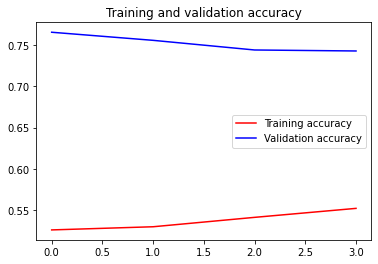

<Figure size 432x288 with 0 Axes>

In [84]:
import matplotlib.pyplot as plt
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

**Accuracy and Loss Model 2**

In [85]:
# Final evaluation of the model
scores2 = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores2[1]*100))

312/312 [==============================] - 2s 6ms/step - loss: 0.6955 - accuracy: 0.5095
Accuracy: 50.95%
